In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import nltk
import gensim.downloader as api
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
device = torch.device("cpu")

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [4]:
data_file = 'data/Sentiment.csv'
data = pd.read_csv(data_file)
data = data[['text', 'sentiment']]

In [5]:
glove_model = api.load("glove-wiki-gigaword-100")

In [6]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [7]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', 'url', text)

    text = re.sub(r'\S+@\S+', 'email', text)

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]

    # Stemming
    tokens = [porter_stemmer.stem(token) for token in tokens]

    return tokens

In [8]:
def text_to_glove_embeddings(text, glove_model):
    tokens = preprocess_text(text)
    print(tokens)

    embeddings = [glove_model.get_vector(token) for token in tokens if token in glove_model]

    if len(embeddings) == 0:
        return np.zeros((1, glove_model.vector_size))

    return embeddings

In [9]:
def pad_sequences(sequences, max_length, embedding_dim):
    padded_sequences = np.zeros((len(sequences), max_length, embedding_dim))
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq
    return padded_sequences

In [10]:
data["text_embeddings"] = data["text"].apply(lambda x: text_to_glove_embeddings(x, glove_model))
max_length = data["text_embeddings"].apply(len).max()
X = pad_sequences(data["text_embeddings"].values, max_length, glove_model.vector_size)
y = (data["sentiment"] == 'Positive').values.astype(int)

['rt', 'nancyleegrahn', 'everyon', 'feel', 'climat', 'chang', 'question', 'last', 'night', 'exactli', 'gopdeb']
['rt', 'scottwalk', 'didnt', 'catch', 'full', 'gopdeb', 'last', 'night', 'scott', 'best', 'line', '90', 'second', 'walker16', 'url']
['rt', 'tjmshow', 'mention', 'tamir', 'rice', 'gopdeb', 'held', 'cleveland', 'wow']
['rt', 'robgeorg', 'carli', 'fiorina', 'trend', 'hour', 'debat', 'men', 'justcomplet', 'gopdeb', 'say', 'she', '…']
['rt', 'danscavino', 'gopdeb', 'w', 'realdonaldtrump', 'deliv', 'highest', 'rate', 'histori', 'presidenti', 'debat', 'trump2016', 'url']
['rt', 'gregabbotttx', 'tedcruz', 'first', 'day', 'rescind', 'everi', 'illeg', 'execut', 'action', 'taken', 'barack', 'obama', 'gopdeb', 'foxnew']
['rt', 'warriorwoman91', 'like', 'happi', 'heard', 'go', 'moder', 'anymor', 'gopdeb', 'megynkelli', 'url']
['go', 'msnbc', 'live', 'thomasarobert', 'around', '2', 'pm', 'et', 'gopdeb']
['deer', 'headlight', 'rt', 'lizzwinstead', 'ben', 'carson', 'may', 'brain', 'surgeon'

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

In [13]:
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
input_size = glove_model.vector_size
hidden_size = 256
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    train_preds = []
    train_true = []
    with torch.no_grad():
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            train_preds.extend(preds)
            train_true.extend(batch_y.cpu().numpy())

    train_f1 = f1_score(train_true, train_preds, average='weighted')
    train_accuracy = accuracy_score(train_true, train_preds)

    val_preds = []
    val_true = []
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.float())
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(batch_y.cpu().numpy())

    val_losses.append(val_loss / len(test_loader))

    val_f1 = f1_score(val_true, val_preds, average='weighted')
    val_accuracy = accuracy_score(val_true, val_preds)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Train F1-score: {train_f1:.4f}, Train Accuracy: {train_accuracy:.4f}, Val F1-score: {val_f1:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/100], Loss: 0.4328, Train F1-score: 0.7666, Train Accuracy: 0.8397, Val F1-score: 0.7549, Val Accuracy: 0.8314
Epoch [2/100], Loss: 0.3902, Train F1-score: 0.7664, Train Accuracy: 0.8396, Val F1-score: 0.7549, Val Accuracy: 0.8314
Epoch [3/100], Loss: 0.3698, Train F1-score: 0.8459, Train Accuracy: 0.8437, Val F1-score: 0.8285, Val Accuracy: 0.8293
Epoch [4/100], Loss: 0.3576, Train F1-score: 0.8165, Train Accuracy: 0.8577, Val F1-score: 0.8079, Val Accuracy: 0.8523
Epoch [5/100], Loss: 0.3446, Train F1-score: 0.8607, Train Accuracy: 0.8747, Val F1-score: 0.8365, Val Accuracy: 0.8552
Epoch [6/100], Loss: 0.3333, Train F1-score: 0.8532, Train Accuracy: 0.8762, Val F1-score: 0.8276, Val Accuracy: 0.8552
Epoch [7/100], Loss: 0.3166, Train F1-score: 0.8780, Train Accuracy: 0.8890, Val F1-score: 0.8354, Val Accuracy: 0.8516
Epoch [8/100], Loss: 0.3032, Train F1-score: 0.8837, Train Accuracy: 0.8880, Val F1-score: 0.8453, Val Accuracy: 0.8516
Epoch [9/100], Loss: 0.2854, Train F1-sc

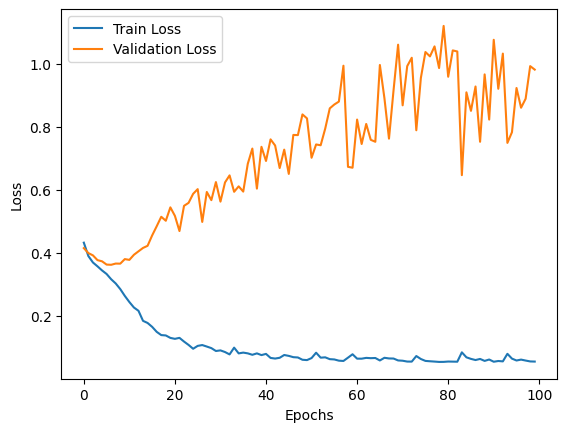

In [16]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

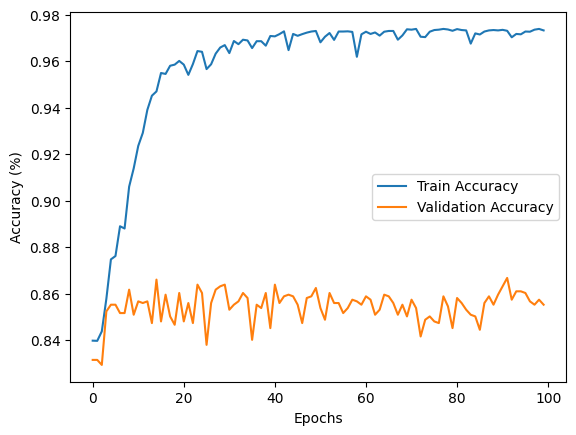

In [17]:
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

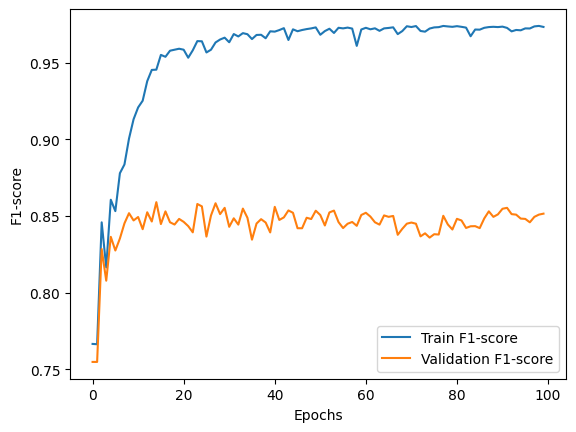

In [18]:
plt.figure()
plt.plot(train_f1_scores, label='Train F1-score')
plt.plot(val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()